# Building an Inverse Image Search Service

Leveraging the power of transfer learning can be very useful in many applications. Particularly, in this notebook we'll harness the readiness of pre-trained network to build an inverse image search engine or, more clearly, a "search by example" service.

Of course, all deep learning tasks begin with data acquisition, so this will be no different. 

The images we will use will be a subset of Imagenet and then passed through a pre-trained network to compile a "embedding" dictionary that'll later on will allow us to fetch similar images using a simple nearest neighbor search.

## Prerequisites

Let's import the libraries we'll need.

In [1]:
%matplotlib inline

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import random
import os
from keras.models import Model
import numpy as np
import glob
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


## Using Images from Imagenet

Imagenet is an enormous corpus of Images that span among many hundreds of classes. Of course, training a network from scratch on a dataset this big is a titanic endeavor. That's why most of the pretrained models we use in Keras have been trained on Imagenet already, probably for lots and epochs and with lots of computational power.

Imagenet alone is around 100GB big. However, we can workaround this volume constraint by using a subset of it. In this project, we use a dataset called [Tiny ImageNet](https://tiny-imagenet.herokuapp.com/), which, as it name suggests, is a way smaller version of the well known dataset. 

It is comprissed of 200 classes, where each has 500 training images, 50 validation images and 50 test images. 

However, our goal is to use these images to create an embedding space that we'll use as the neighborhood to support our inverse image search engine. That's why we don't mind using all of the images, independently of their original intent.

We define the source folder of the Tiny ImageNet dataset in `TINY_IMAGENET_SOURCE`.

In [2]:
TINY_IMAGENET_SOURCE = '/floyd/input/tiny_imagenet_200'

Images in `val` and `test` subfolders are inside a directory called `images`. Images inside `training` are stored in a directory called `images` inside another subfolder named after the ID of the class they belong to. Hence, in order to load them all into memory, we need to take this into account. 

Let's write a function to do the heavy-lifting for us.

In [3]:
def load_subset(source, size=10000):
    validation_pattern = os.path.join(source, 'val', 'images', '*')
    test_pattern = os.path.join(source, 'test', 'images', '*')
    train_pattern = os.path.join(source, 'train', '*', 'images', '*')
    
    all_source_images_paths = glob.glob(validation_pattern) + glob.glob(test_pattern) + glob.glob(train_pattern)
    
    # -1 signals we should use all available images.
    if size == -1:
        sample_images_paths = all_source_images_paths
    else:
        sample_images_paths = random.sample(all_source_images_paths, size)
    
    images = []
    for picture in sample_images_paths:
        try:
            i = mpimg.imread(picture)
            
            # Only keep those images with three dimensions.
            if len(i.shape) == 3:
                images.append(i)
        
        except Exception as e:
            print(f'Could not load image {picture}. Reason: {e}')

    return images

images = load_subset(TINY_IMAGENET_SOURCE, size=-1)
print(f'Loaded {len(images)} images.')

Loaded 117822 images.


Now that we loaded a couple of images, let's see one of them.

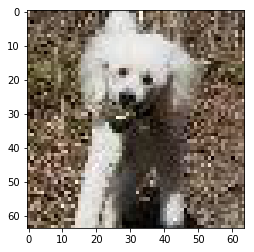

In [4]:
SAMPLE_INDEX = 0  # Change to see another image.

assert 0 <= SAMPLE_INDEX < len(images)

plt.imshow(images[SAMPLE_INDEX])

It seems we're good to go. Let's move on!

## Projecting Images into an N-Dimensional Space

Given the set of images we gathered in the last step, we can organize them such that similar images are near each other in the vectorial space produced by the last-but-one layer of a pre-trained network. In other words, treat the weights of this layer as _image embeddings_.

Let's start by loading a pre-trained model. This time will opt to use `InceptionV3`.

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Our target layer is `avg_pool`, which produces outputs of 2048 elements. This will be the dimension of our image embeddings:

In [6]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

Good. Let's create a function that given an image, return its vectorial representation:

In [7]:
def get_vector(model, img):
    if not isinstance(img, list):
        images = [img]
    else:
        images = img
        
    target_size = (299, 299)  # Default for ImagenetV3
    images = [cv2.resize(i, target_size) for i in images]

    pre_processed_images = preprocess_input(np.asarray(images))
    
    return model.predict(pre_processed_images)

processed_batch = get_vector(model, images[:10])
print(f'Processed batch shape: {processed_batch.shape}')

Processed batch shape: (10, 2048)


In order to not abuse of our RAM, let's process our dataset in chunks. If your RAM can take it, increase the `CHUNK_SIZE` or even process the whole dataset at once! 

For this notebook, I used a FloydHub instance with 61 GB of RAM.

In [8]:
CHUNK_SIZE = 4096

processed_chunks = []
for chunk_index in range(0, len(images), CHUNK_SIZE):
    chunk = images[chunk_index:(chunk_index + CHUNK_SIZE)]
    processed_chunk = get_vector(model, chunk)
    
    processed_chunks.append(processed_chunk)
    
    print(f'Processed {chunk_index + CHUNK_SIZE} images of {len(images)}')
    
vectors = np.concatenate(processed_chunks)

Processed 4096 images of 117822
Processed 8192 images of 117822
Processed 12288 images of 117822
Processed 16384 images of 117822
Processed 20480 images of 117822
Processed 24576 images of 117822
Processed 28672 images of 117822
Processed 32768 images of 117822
Processed 36864 images of 117822
Processed 40960 images of 117822
Processed 45056 images of 117822
Processed 49152 images of 117822
Processed 53248 images of 117822
Processed 57344 images of 117822
Processed 61440 images of 117822
Processed 65536 images of 117822
Processed 69632 images of 117822
Processed 73728 images of 117822
Processed 77824 images of 117822
Processed 81920 images of 117822
Processed 86016 images of 117822
Processed 90112 images of 117822
Processed 94208 images of 117822
Processed 98304 images of 117822
Processed 102400 images of 117822
Processed 106496 images of 117822
Processed 110592 images of 117822
Processed 114688 images of 117822
Processed 118784 images of 117822


## Finding Nearest Neighbors in High-Dimensional Spaces

Now that all images in the dataset have been projected into a 2408D space, we can build a `k-Nearest Neighbors` model on it to then fetch the most similar images (i.e., neighbors) in this space.

In [9]:
NUMBER_OF_NEIGHBORS = 10
n_neighbors = NearestNeighbors(n_neighbors=NUMBER_OF_NEIGHBORS, algorithm='ball_tree')
neighbors = n_neighbors.fit(vectors)

Let's see what are the neighbors of our always reliable Pug image. For that matter, we will use the following function

In [10]:
def get_and_plot_neighbors(model, neighbors, images, image_path):
    pug_image = mpimg.imread(image_path)
    pug_vector = get_vector(model, pug_image)

    distances, indices = neighbors.kneighbors(pug_vector)


    plt.figure(figsize=(20,10))
    columns = 5

    for i, (index, distance) in enumerate(zip(indices[0], distances[0])):
        plt.subplot(len(distances[0]) / columns + 1, columns, i + 1)
        plt.title(f'Distance: {distance}')
        plt.imshow(images[index])

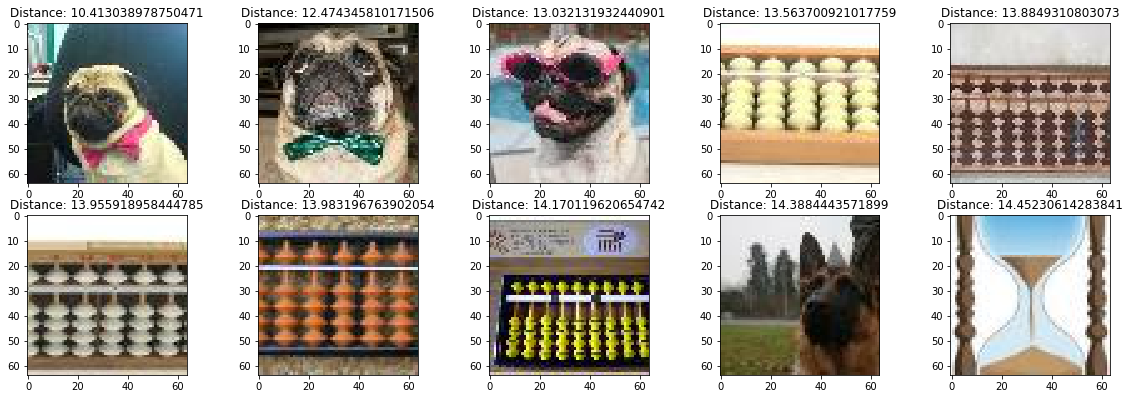

In [11]:
get_and_plot_neighbors(model, neighbors, images, 'data/pug.jpeg')

That's impressive. Not only the three closest neighbors are dogs, but Pugs! We also see another images related with things that are CLEARLY not a Pug, such as hourglass!

Let's try now with a car:

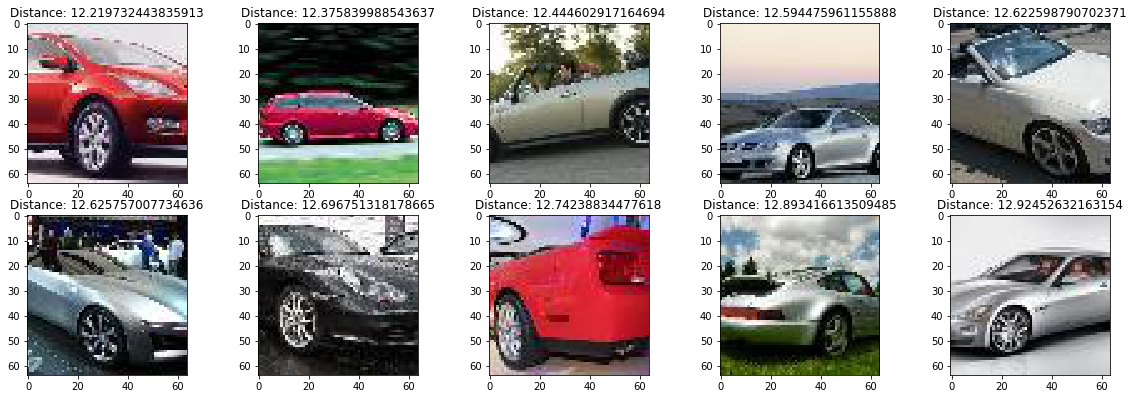

In [12]:
get_and_plot_neighbors(model, neighbors, images, 'data/tesla.jpg')

It seems our image search engine recognizes the **car** concept pretty well. 

Let's try with an image of a guitar:

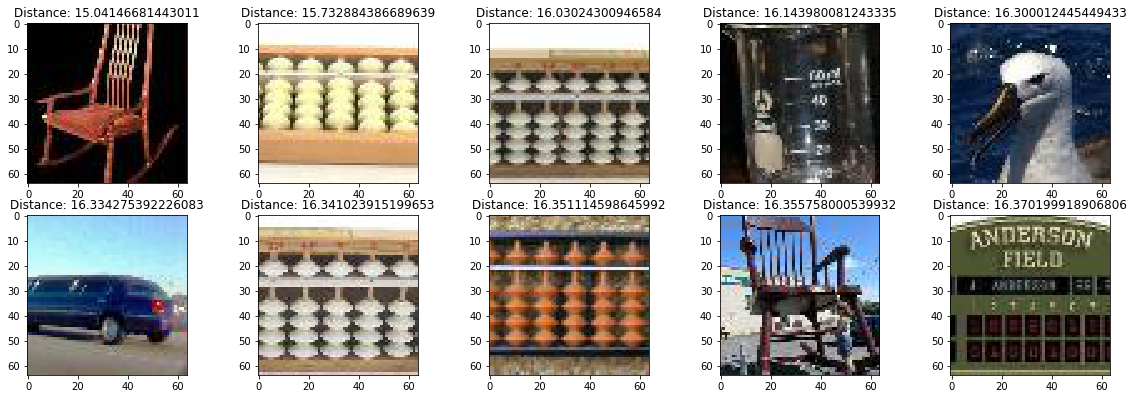

In [13]:
get_and_plot_neighbors(model, neighbors, images, 'data/guitar.jpg')

This is interesting. None of the neighbouring images correspond to a guitar. It seems, though, that the color is encoded in the vector representation of the images, because 6 of these have similar colors than the guitar image we passed to the network. This might be a consequence of insufficient data in our dataset, or just the **guitar** category is not present in the Tiny ImageNet corpus of images. 